In [258]:
import os
import math
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, cdist
from mpl_toolkits.mplot3d import Axes3D
import soundfile as sf
from prettytable import PrettyTable
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy.signal import hilbert, butter, filtfilt, medfilt, lfilter, wiener, convolve

In [259]:
fruit_types      = ['pera', 'banana', 'manzana', 'naranja']
audios           = {fruit: [] for fruit in fruit_types}
training_path    = '../../../dataset/audios/training'
original_path    = os.path.join(training_path, 'original')
processed_path   = os.path.join(training_path, 'processed')
model_file       = 'model.pkl'
model            = dict.fromkeys(['pca', 'features', 'scaler'])

In [260]:
original = {fruit: [] for fruit in fruit_types}
for dirname, _, filenames in os.walk(original_path):
    subdir = os.path.basename(dirname)
    if subdir in fruit_types:
        original[subdir].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

In [261]:
processed = {fruit: [] for fruit in fruit_types}
for dirname, _, filenames in os.walk(processed_path):
    subdir = os.path.basename(dirname)
    if subdir in fruit_types:
        processed[subdir].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

In [262]:
FRAME_SIZE = 1024 # In the documentation says it's convenient for speech.C
HOP_SIZE   = int(FRAME_SIZE/2)

In [263]:
def load_audio(audiofile):
    test_audio, sr = librosa.load(audiofile, sr = None)
    duration = librosa.get_duration(filename=audiofile, sr=sr)
    return test_audio, sr, duration

In [264]:
def time_vector(signal, duration):
    return np.linspace(0, duration, len(signal))

In [265]:
def rms(signal):
    return librosa.feature.rms(y=signal, frame_length = FRAME_SIZE, hop_length = HOP_SIZE)

In [266]:
def normalize(signal):
    peak = np.max(signal)
    signal/=peak
    return signal

In [267]:
def low_pass_filter(signal, sr, cutoff_frequency = 5000):
    nyquist = 0.5 * sr
    cutoff = cutoff_frequency / nyquist
    b, a = butter(N=6, Wn=cutoff, btype='low', analog=False, output='ba')
    filtered = lfilter(b, a, signal)
    return filtered

In [268]:
def envelope(signal):
    analytic_signal = hilbert(signal)
    return np.abs(analytic_signal)

In [269]:
def smooth_envelope(signal, sr, cutoff_frequency=10.0):
    return low_pass_filter(envelope(signal), sr, cutoff_frequency)

In [270]:
#2d
def plot_features2d(features):
    fig = plt.figure()
    colors = dict(zip(fruit_types,['green','yellow','red','orange']))
    

    for fruit, points in features.items():
        plt.scatter(points[:, 0], points[:, 1], c = colors[fruit], label=fruit)

    plt.xlabel('Eje X')
    plt.ylabel('Eje Y')
    plt.show()

In [271]:
#3d
def plot_features3D(features:dict):
    fig = plt.figure()
    colors = dict(zip(fruit_types,['green','yellow','red','orange']))
    ax = fig.add_subplot(111, projection='3d')
    for fruit, points in features.items():
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors[fruit], marker='o', label=fruit)
        #ax.scatter(centers[fruit][:, 0], centers[fruit][:, 1], centers[fruit][:, 2], c=center_colors[fruit], marker='o', label=f"{fruit}-center")

    # configure labels
    ax.set_xlabel('Eje X')
    ax.set_ylabel('Eje Y')
    ax.set_zlabel('Eje Z')
    plt.show()

In [272]:
def calculate_split_frequency_bin(split_frequency, sample_rate, num_frequency_bins):
    """Infer the frequency bin associated to a given split frequency."""
    
    frequency_range = sample_rate / 2
    frequency_delta_per_bin = frequency_range / num_frequency_bins
    split_frequency_bin = math.floor(split_frequency / frequency_delta_per_bin)
    return int(split_frequency_bin)

In [273]:
def band_energy_ratio(spectrogram, split_frequency, sample_rate):
    """Calculate band energy ratio with a given split frequency."""
    
    split_frequency_bin = calculate_split_frequency_bin(split_frequency, sample_rate, len(spectrogram[0]))
    band_energy_ratio = []
    
    # calculate power spectrogram
    power_spectrogram = np.abs(spectrogram) ** 2
    power_spectrogram = power_spectrogram.T
    for frame in power_spectrogram:
        sum_power_low_frequencies = frame[:split_frequency_bin].sum()
        sum_power_high_frequencies = frame[split_frequency_bin:].sum()
        band_energy_ratio_current_frame = sum_power_low_frequencies / (sum_power_high_frequencies + sum_power_low_frequencies)
        band_energy_ratio.append(band_energy_ratio_current_frame)
    
    return np.array(band_energy_ratio)

C:\Users\Juan\AppData\Local\Temp\ipykernel_5996\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)
C:\Users\Juan\AppData\Local\Temp\ipykernel_5996\3751504528.py:13: RuntimeWarning: invalid value encountered in scalar divide
  band_energy_ratio_current_frame = sum_power_low_frequencies / (sum_power_high_frequencies + sum_power_low_frequencies)


BER: ['nan', 'nan', 'nan', '54.17', '2.71', '3.51', '2.17', '0.09', '7.26', '14.20', '0.24', '1.43', '3.49', '0.92', '1.35', '0.14', '6.14', '5.26', '0.13', '0.13', '0.15', '0.05', '0.00', '0.01', '0.04', '0.11', '0.16', '0.42', '3.74', '1.20', '3.38', '3.62', '0.53', '0.28', '0.06', '0.37', '0.61', '0.18', '0.16', '2.28', '1.46', '0.35', '0.46', '0.54', '2.56', '8.86', '9.24', '11.22', '12.51', '9.43', '27.81', '59.50', '27.26', '33.76', '22.73', '43.03', '14.31', '100.00', '67.93', '19.79', '75.64', '93.69', '71.34']


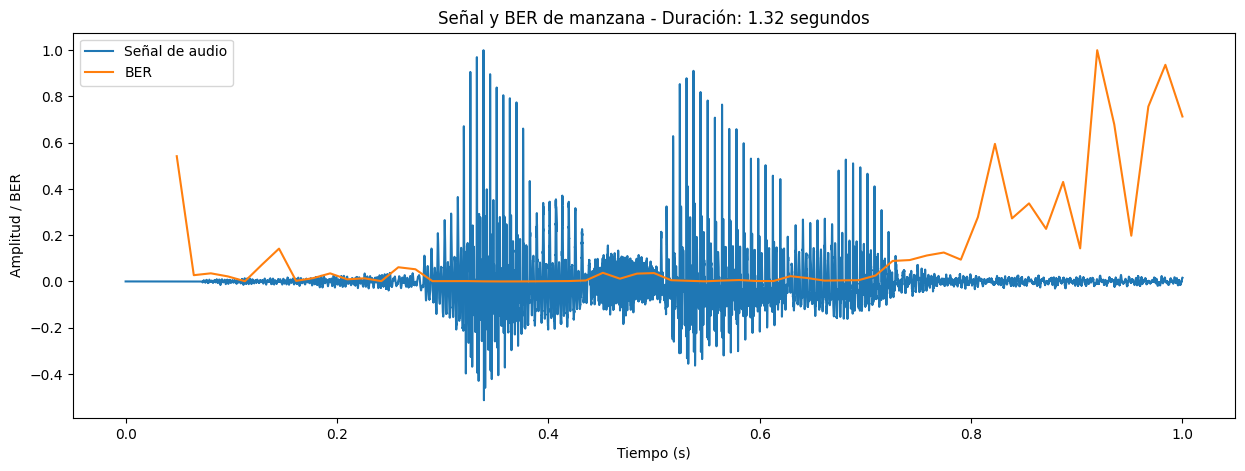

BER: ['5.83', '100.00', '92.82', '26.33', '34.91', '8.65', '2.55', '3.24', '27.60', '20.82', '59.04', '22.44', '25.64', '5.78', '29.62', '20.67', '44.64', '42.24', '13.20', '39.06', '13.38', '16.46', '8.83', '37.47', '27.05', '32.24', '39.92', '23.44', '25.18', '28.55', '7.55', '3.79', '20.26', '11.24', '54.20', '60.11', '39.80', '42.65', '18.04', '58.98', '64.75', '28.80', '4.17', '9.57', '11.07', '12.70', '15.89', '16.45', '19.26', '34.41', '27.68', '24.21', '30.99', '79.59', '87.81', '7.41', '7.17', '3.35', '9.76', '2.70', '4.73', '6.71', '9.67', '14.44', '25.89', '12.65', '7.32', '8.40', '7.66', '17.29', '39.06', '25.91', '31.55', '44.70', '19.32', '24.37', '18.39', '22.23', '84.09', '21.45', '39.18', '33.12', '79.32', '40.55', '31.90', '81.82', '58.48', '31.22', '94.11', '79.54', '50.02', '54.70', '72.48']


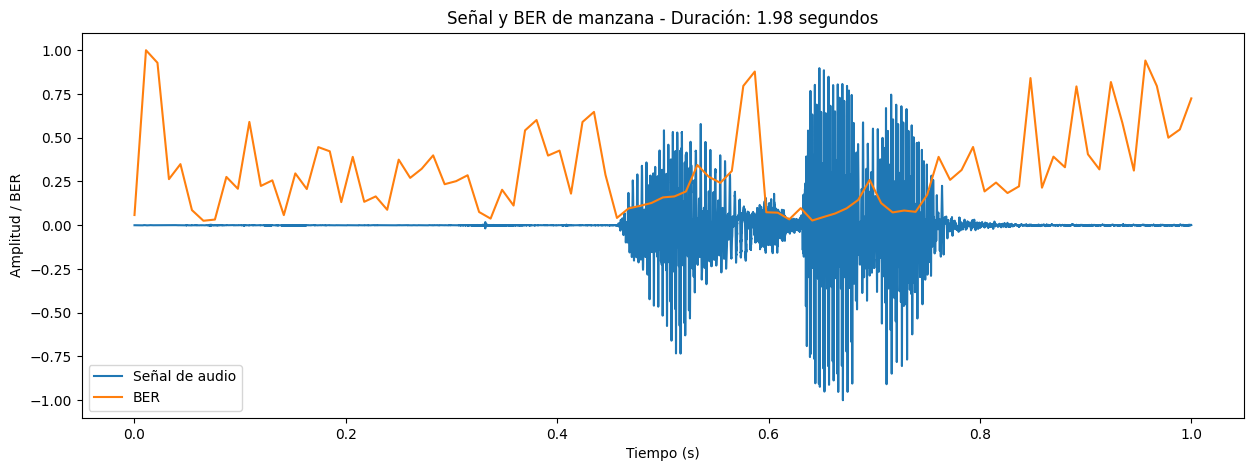

BER: ['1.19', '8.71', '1.97', '30.29', '23.59', '15.55', '19.63', '15.88', '6.81', '35.72', '19.68', '13.11', '15.72', '37.10', '62.42', '77.86', '66.99', '58.96', '82.98', '49.76', '45.09', '48.75', '47.37', '65.61', '100.00', '8.27', '13.76', '17.76', '15.73', '13.23', '11.69', '12.13', '7.16', '6.91', '7.50', '7.85', '8.59', '10.62', '10.31', '8.76', '8.10', '9.71', '15.35', '21.19', '23.70', '4.32', '2.07', '3.36', '1.46', '2.32', '4.42', '4.79', '4.70', '6.10', '5.85', '6.43', '5.29', '6.31', '7.08', '7.61', '11.35', '27.67', '43.30', '32.17', '11.75', '31.00', '21.90', '13.81', '56.36', '53.58', '27.19', '56.93', '83.14']


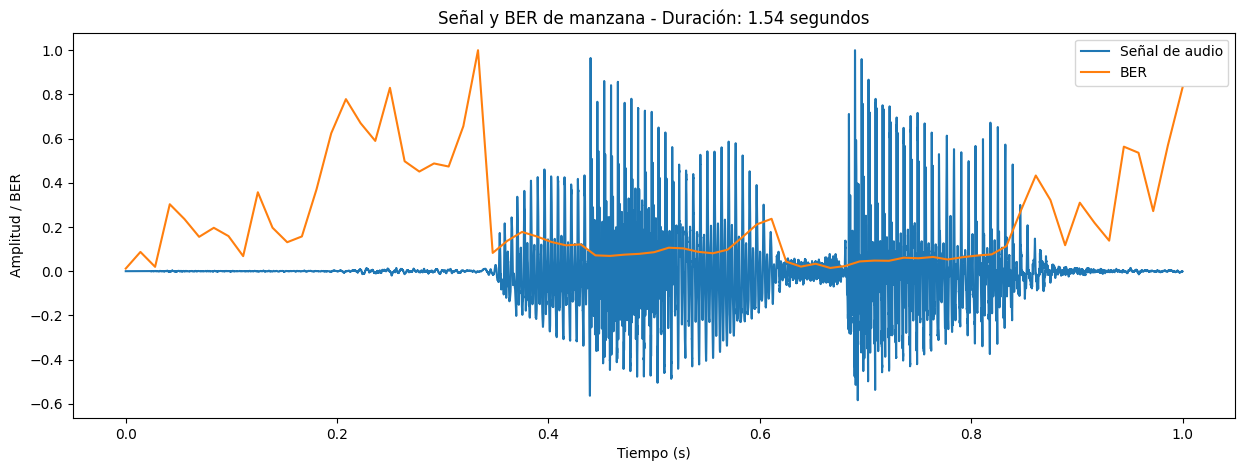

BER: ['1.19', '8.71', '1.97', '30.29', '23.59', '15.55', '19.63', '15.88', '6.81', '35.72', '19.68', '13.11', '15.72', '37.10', '62.42', '77.86', '66.99', '58.96', '82.98', '49.76', '45.09', '48.75', '47.37', '65.61', '100.00', '8.27', '13.76', '17.76', '15.73', '13.23', '11.69', '12.13', '7.16', '6.91', '7.50', '7.85', '8.59', '10.62', '10.31', '8.76', '8.10', '9.71', '15.35', '21.19', '23.70', '4.32', '2.07', '3.36', '1.46', '2.32', '4.42', '4.79', '4.70', '6.10', '5.85', '6.43', '5.29', '6.31', '7.08', '7.61', '11.35', '27.67', '43.30', '32.17', '11.75', '31.00', '21.90', '13.81', '56.36', '53.58', '27.19', '56.93', '83.14']


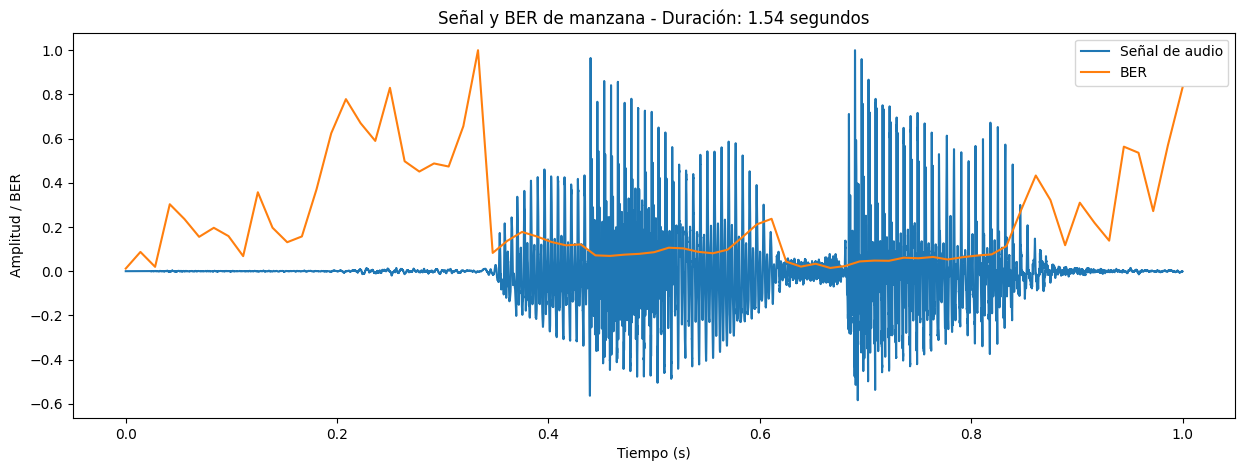

BER: ['0.46', '2.03', '0.74', '4.27', '14.27', '9.07', '10.62', '22.52', '8.17', '9.72', '11.46', '7.50', '10.52', '8.51', '6.98', '9.54', '7.27', '6.92', '2.69', '4.53', '5.09', '6.24', '4.67', '5.07', '7.14', '18.67', '46.58', '40.78', '4.41', '3.64', '4.11', '2.87', '3.01', '3.20', '4.23', '8.34', '6.01', '7.91', '17.44', '9.86', '23.37', '57.05', '51.22', '19.48', '3.81', '32.79', '21.44', '11.17', '24.20', '19.15', '33.19', '24.59', '51.43', '72.86', '95.82', '80.88', '54.93', '81.25', '49.08', '47.20', '76.33', '63.03', '100.00', '93.32', '39.94', '39.03', '23.12', '16.76', '15.94', '11.67', '14.97', '26.42', '19.61', '50.43']


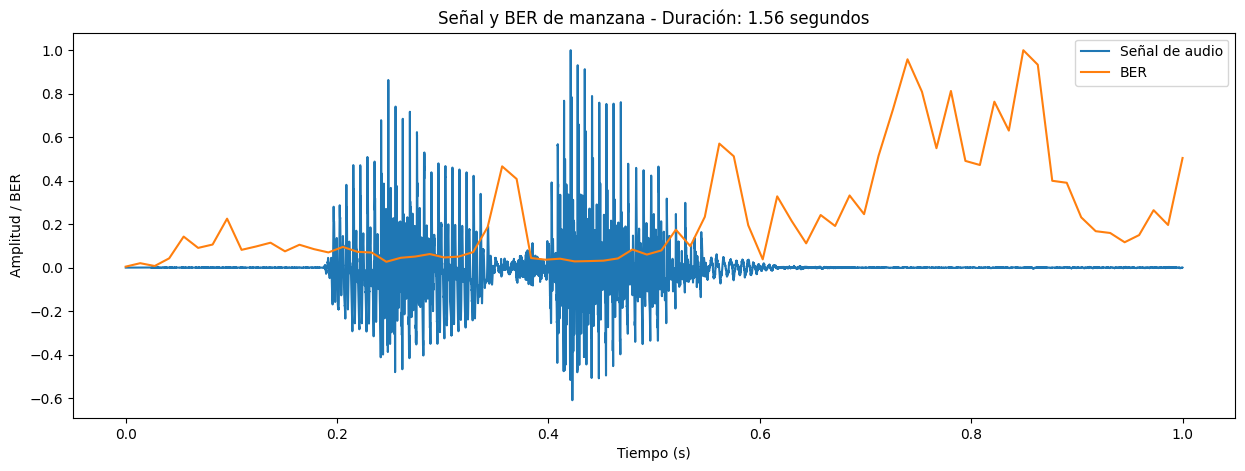

BER: ['0.86', '2.76', '13.54', '20.53', '26.53', '8.22', '50.79', '19.96', '63.04', '61.52', '36.94', '53.26', '48.77', '29.64', '34.77', '62.09', '72.83', '39.66', '61.70', '86.81', '77.70', '97.50', '90.88', '46.64', '79.58', '34.73', '79.36', '69.39', '93.18', '84.49', '70.76', '40.52', '90.23', '79.09', '66.34', '76.41', '55.10', '31.35', '87.81', '24.29', '72.14', '46.06', '31.26', '28.34', '29.90', '46.53', '32.94', '60.08', '80.63', '73.88', '36.47', '60.86', '89.47', '22.18', '71.69', '25.81', '25.73', '34.48', '38.88', '35.23', '31.16', '14.39', '24.97', '23.88', '29.34', '42.40', '40.48', '36.75', '39.83', '49.96', '90.25', '65.18', '13.12', '22.42', '9.46', '8.48', '13.12', '18.67', '23.58', '32.83', '32.20', '24.28', '33.01', '33.03', '41.11', '76.47', '96.64', '100.00', '95.48', '74.96', '79.19', '57.52', '58.14', '90.49', '80.35', '78.97', '68.85', '59.40', '84.99', '85.68', '75.51', '62.61', '73.72', '61.97', '60.20', '62.69', '59.44', '53.76']


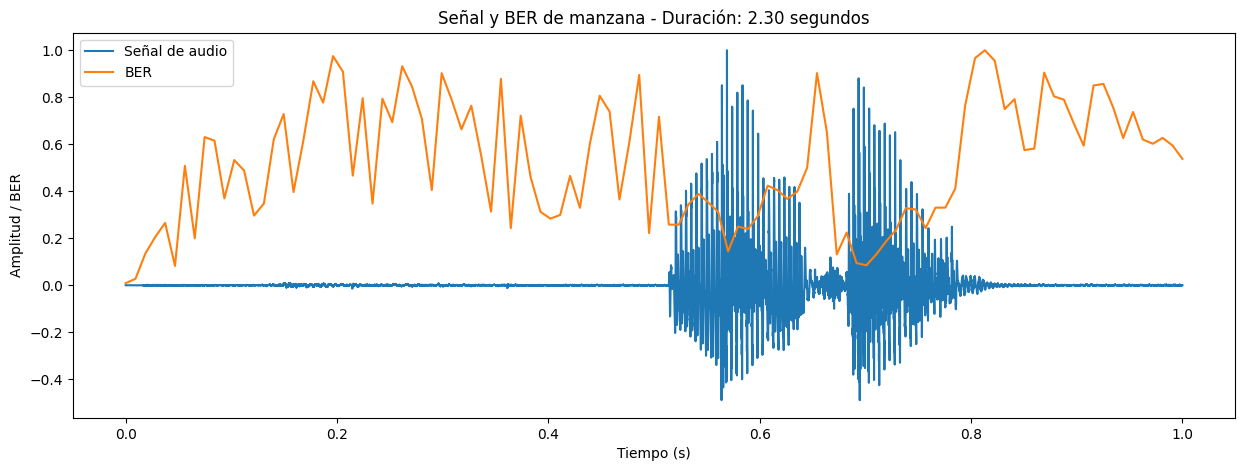

BER: ['0.66', '10.66', '44.33', '28.00', '43.05', '10.93', '26.96', '18.52', '16.05', '35.65', '33.69', '53.22', '36.29', '42.50', '93.89', '85.43', '77.37', '41.57', '67.51', '43.68', '83.77', '69.24', '73.68', '62.89', '70.30', '77.00', '97.15', '100.00', '76.36', '86.27', '60.79', '77.14', '73.53', '92.12', '89.06', '73.11', '80.23', '77.38', '75.48', '90.67', '95.61', '49.59', '23.62', '24.69', '69.06', '88.44', '67.38', '84.95', '73.62', '63.22', '51.65', '88.20', '89.56', '75.37', '73.74', '87.42', '35.38', '53.01', '45.36', '18.93', '14.67', '14.01', '13.28', '8.54', '10.22', '11.72', '14.34', '16.36', '21.41', '16.51', '18.80', '25.63', '45.57', '66.62', '82.29', '41.89', '23.06', '22.15', '7.58', '6.41', '10.98', '14.81', '17.86', '23.74', '28.26', '23.91', '24.49', '19.90', '18.63', '71.43', '91.30', '81.81', '58.87', '58.28', '26.70', '56.08', '58.91', '79.22', '85.22', '97.99', '82.59']


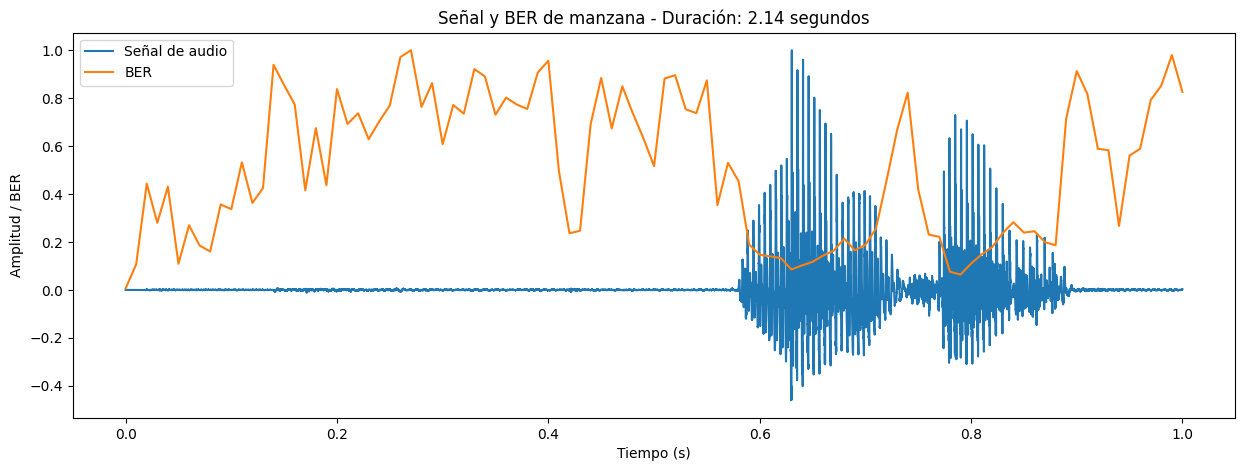

BER: ['1.09', '0.42', '0.13', '0.77', '3.46', '2.25', '5.14', '15.61', '5.20', '22.90', '14.38', '4.50', '8.64', '1.50', '37.56', '66.33', '63.30', '66.54', '75.87', '88.04', '50.85', '31.43', '25.43', '81.59', '94.03', '87.70', '80.76', '47.84', '91.19', '90.84', '21.90', '25.89', '13.86', '10.29', '8.99', '8.87', '5.59', '4.67', '4.69', '5.13', '6.46', '8.47', '8.70', '14.87', '39.69', '57.86', '81.59', '15.19', '12.64', '6.34', '3.86', '4.16', '7.63', '8.81', '10.03', '10.41', '7.65', '6.63', '8.86', '15.35', '65.79', '100.00', '96.03', '97.10', '91.69', '73.62', '66.41', '49.83', '40.25', '28.92', '41.70', '77.56', '52.29', '38.38', '24.92', '32.22', '60.95', '63.76', '62.42', '57.65', '38.21', '70.21', '45.35', '53.66', '90.42', '71.29', '57.12', '58.87']


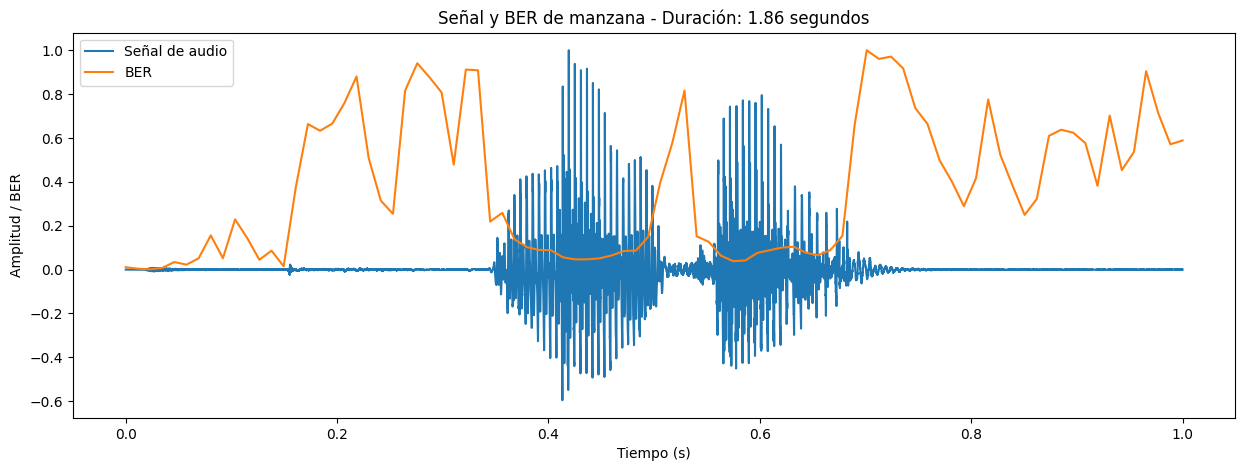

BER: ['0.35', '0.40', '0.78', '0.70', '0.51', '0.40', '0.78', '0.70', '0.51', '0.40', '0.78', '0.70', '0.51', '0.40', '0.78', '0.70', '9.19', '48.91', '47.05', '26.03', '62.45', '20.19', '16.62', '91.70', '52.13', '21.96', '77.69', '66.15', '32.14', '41.14', '48.59', '67.48', '47.07', '68.29', '93.06', '36.15', '51.57', '58.81', '33.92', '74.06', '87.97', '31.34', '52.98', '74.10', '61.04', '47.22', '41.39', '80.56', '40.58', '33.40', '35.25', '22.50', '53.04', '60.87', '21.62', '17.63', '17.38', '21.98', '27.04', '30.75', '50.26', '42.34', '42.74', '47.11', '52.01', '62.67', '92.57', '86.58', '23.94', '4.89', '9.19', '19.56', '10.01', '11.40', '11.70', '16.34', '23.39', '34.17', '40.30', '46.94', '36.95', '68.00', '75.09', '94.92', '60.79', '42.35', '60.07', '100.00', '23.79', '65.83', '72.89', '27.95', '46.50', '86.47']


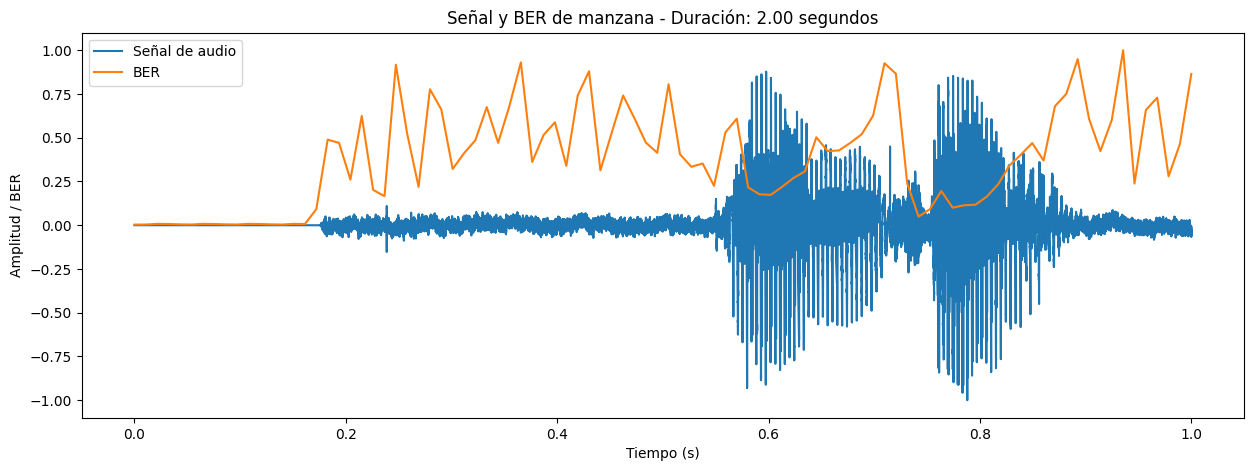

BER: ['0.31', '0.35', '0.69', '0.62', '0.45', '0.35', '0.69', '0.62', '0.45', '0.35', '0.69', '0.62', '0.45', '0.35', '0.69', '0.62', '100.00', '76.42', '41.28', '65.53', '31.01', '53.23', '19.16', '25.61', '52.50', '69.87', '80.03', '51.79', '33.94', '19.11', '42.38', '85.02', '47.59', '67.83', '49.03', '20.86', '67.24', '41.19', '65.49', '78.85', '22.27', '31.97', '39.20', '41.04', '19.74', '37.36', '84.84', '70.36', '28.34', '46.20', '62.16', '34.70', '47.79', '90.16', '94.63', '80.00', '60.95', '37.45', '33.25', '28.50', '14.89', '16.84', '15.60', '14.57', '15.96', '22.63', '29.70', '26.31', '30.24', '37.72', '62.34', '90.62', '19.85', '4.90', '5.13', '28.31', '12.60', '13.12', '16.97', '18.82', '21.05', '30.04', '40.25', '34.32', '24.06', '34.58', '86.36', '97.92', '42.58', '45.34', '45.82', '12.35', '22.98', '23.85']


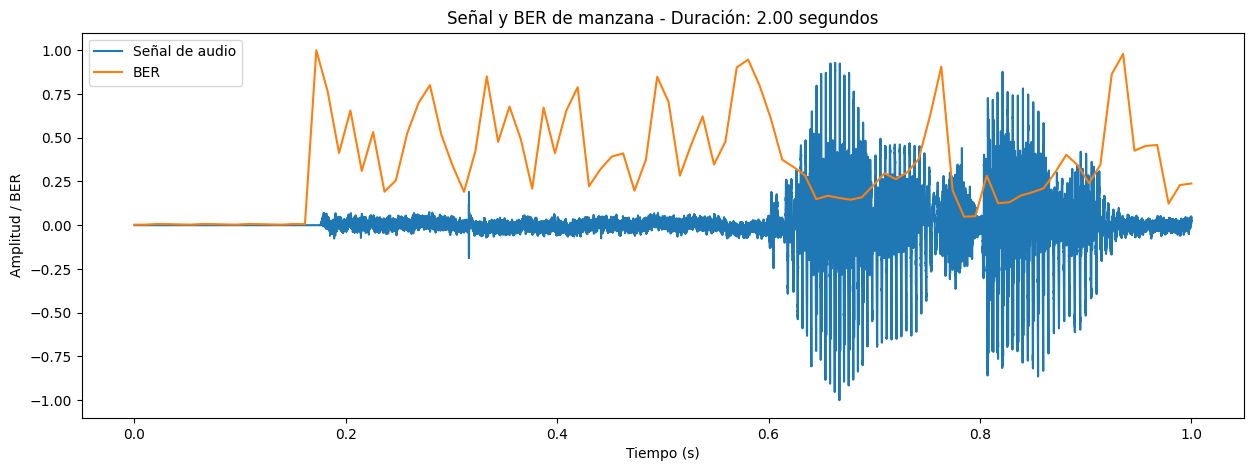

BER: ['0.30', '0.34', '0.66', '0.60', '0.43', '0.34', '0.66', '0.60', '0.43', '0.34', '0.66', '0.60', '0.43', '0.34', '0.66', '0.60', '28.31', '34.17', '47.05', '31.94', '25.79', '21.85', '32.58', '64.95', '88.55', '70.61', '32.52', '43.01', '55.54', '56.68', '89.03', '73.94', '61.81', '31.40', '20.21', '30.05', '42.74', '50.11', '32.79', '46.23', '24.06', '42.50', '29.32', '39.41', '29.17', '19.45', '18.08', '16.13', '15.31', '16.59', '21.99', '32.42', '28.00', '30.66', '35.05', '46.49', '91.13', '97.31', '25.29', '1.80', '14.76', '11.53', '12.69', '13.12', '18.44', '22.93', '25.76', '40.48', '38.61', '29.05', '29.78', '51.37', '100.00', '88.79', '82.87', '53.74', '49.46', '46.45', '54.43', '49.18', '91.25', '35.26', '40.04', '20.03', '37.63', '77.79', '42.40', '74.62', '84.87', '57.10', '96.38', '63.54', '96.98', '80.11']


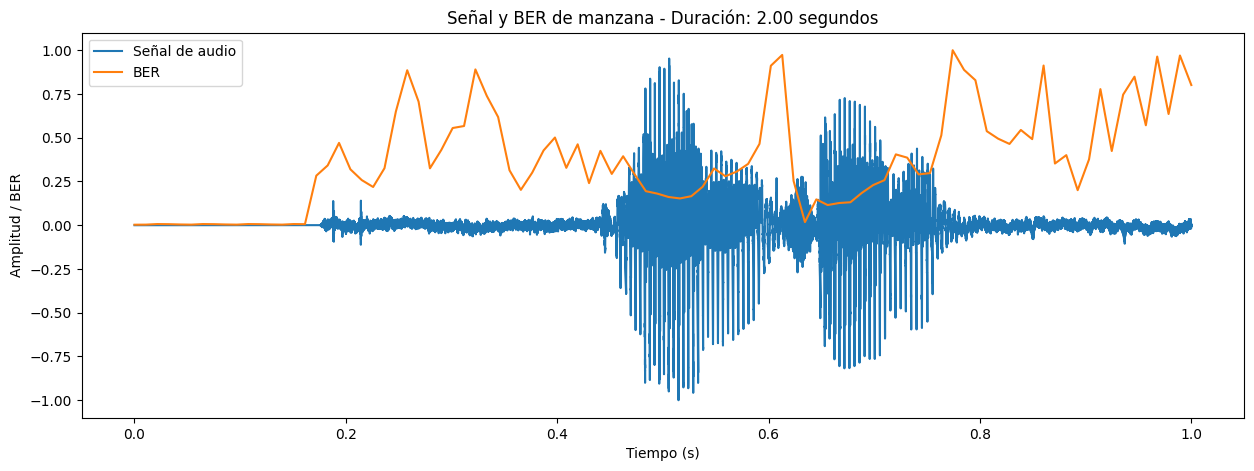

BER: ['nan', 'nan', 'nan', '100.00', '3.01', '3.04', '12.43', '70.32', '35.56', '12.23', '63.73', '22.65', '2.89', '20.67', '25.67', '84.40', '73.81', '45.06', '23.75', '23.25', '4.70', '1.79', '0.66', '0.17', '0.31', '0.23', '0.83', '0.18', '2.33', '14.60', '0.69', '0.18', '4.14', '0.79', '0.23', '0.22', '0.20', '0.78', '1.03', '1.17', '1.49', '2.51', '5.16', '4.38', '3.61', '3.91', '3.46', '3.75', '7.51', '19.77', '36.54', '6.42', '9.99', '5.06', '9.28', '47.71', '27.50', '2.21', '9.97', '14.79', '5.07', '12.10', '23.11', '6.53', '2.97', '9.73', '25.16', '5.06', '52.30', '8.62', '37.45', '34.58', '7.96', '5.96', '1.29']


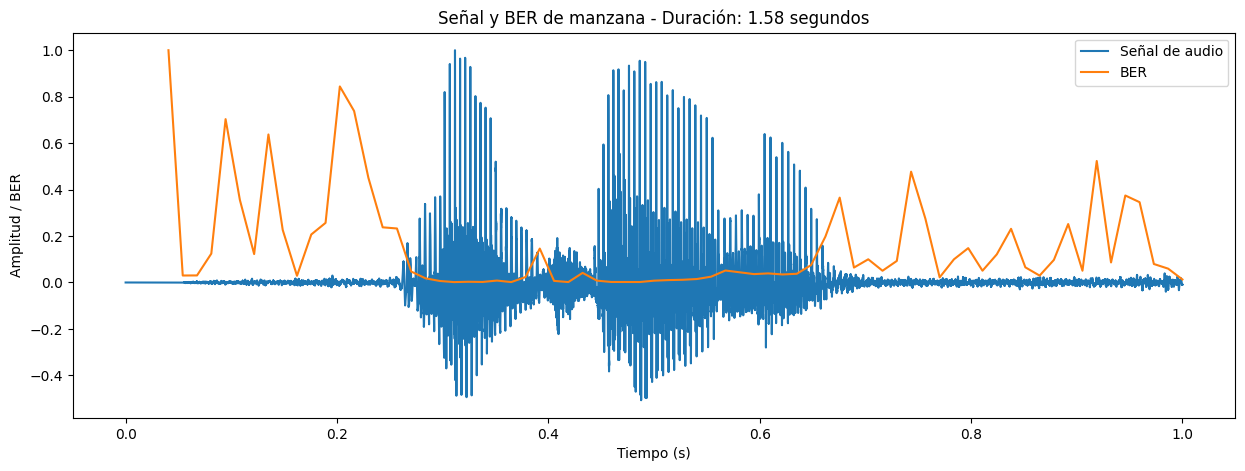

BER: ['0.29', '0.33', '0.64', '0.57', '0.41', '0.33', '0.64', '0.57', '0.41', '0.33', '0.64', '0.57', '0.41', '0.33', '0.64', '0.57', '61.95', '73.25', '71.03', '43.37', '74.47', '46.75', '29.70', '63.79', '52.30', '9.54', '20.20', '21.91', '26.51', '31.56', '56.60', '25.96', '39.17', '11.51', '25.61', '53.50', '20.18', '31.58', '50.17', '56.09', '74.92', '33.97', '46.20', '35.26', '42.73', '26.80', '9.53', '7.96', '7.71', '7.84', '8.80', '9.92', '16.26', '15.57', '15.37', '18.33', '27.56', '59.11', '68.77', '6.17', '1.22', '22.69', '8.49', '7.31', '9.15', '11.86', '17.32', '30.71', '24.20', '16.29', '43.54', '96.46', '76.30', '32.09', '85.64', '72.37', '87.60', '38.64', '48.86', '77.32', '85.68', '100.00', '77.45', '76.88', '76.42', '52.60', '82.10', '42.12', '43.47', '27.92', '59.31', '29.21', '36.85', '35.04']


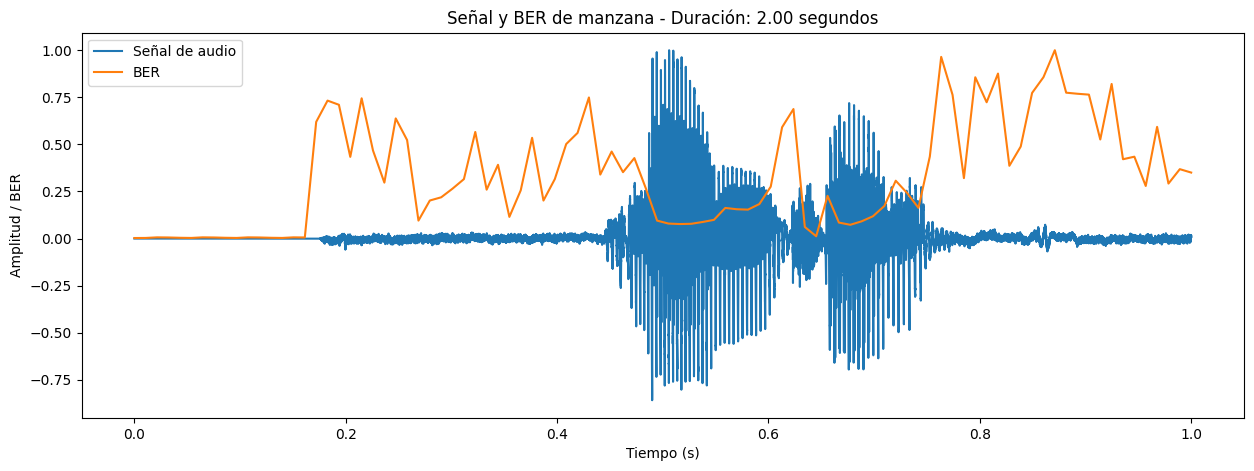

BER: ['97.16', '100.00', '99.91', '99.35', '98.23', '95.57', '98.10', '98.92', '98.80', '99.06', '99.33', '98.96', '98.37', '98.57', '98.93', '97.68', '97.93', '98.85', '90.17', '98.80', '96.97', '78.51', '98.28', '91.82', '90.76', '98.10', '84.49', '82.55', '98.45', '94.80', '94.80', '95.55', '97.86', '93.88', '95.55', '92.70', '92.87', '89.07', '87.55', '91.70', '82.48', '95.10', '57.02', '63.27', '83.15', '38.12', '27.49', '31.81', '52.07', '78.83', '81.11', '83.07', '3.35', '6.78', '3.71', '19.02', '31.99', '18.16', '12.22', '6.73', '10.87', '12.83', '16.97', '9.03', '10.25', '17.97', '62.16', '85.06', '77.81', '65.53', '67.27', '76.63', '88.34', '78.29', '76.99', '78.34', '83.72', '90.01', '87.30', '83.48', '96.53', '70.27', '74.21', '93.02', '92.53', '94.87', '64.89', '94.98', '94.72', '98.09', '94.98', '89.93', '96.29', '98.53', '93.03', '87.75', '97.83', '98.91', '97.10', '99.02', '96.76', '96.09', '87.14', '47.58', '92.60', '7.53', '3.22']


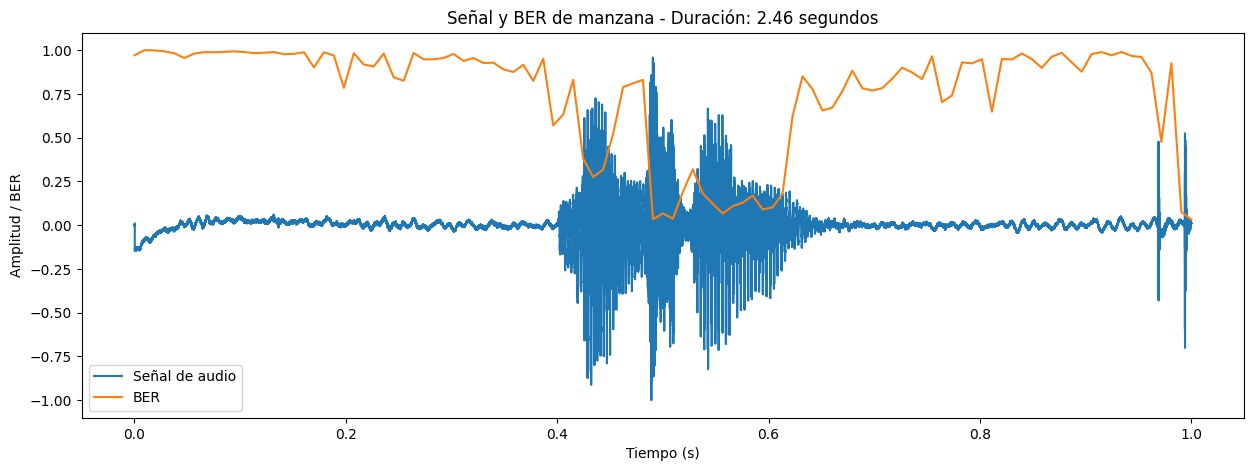

BER: ['nan', 'nan', 'nan', '20.47', '27.06', '18.91', '33.38', '1.99', '68.93', '32.03', '15.94', '40.88', '14.42', '22.79', '4.04', '2.10', '48.37', '26.80', '40.67', '11.02', '24.93', '17.27', '15.65', '60.82', '10.34', '1.26', '1.58', '0.76', '0.53', '0.54', '1.31', '2.45', '3.73', '5.60', '21.47', '1.02', '0.12', '0.99', '2.15', '0.40', '0.16', '0.04', '0.15', '0.17', '0.46', '1.07', '3.19', '2.99', '2.37', '3.99', '3.44', '2.97', '5.50', '5.40', '2.57', '11.93', '3.62', '25.76', '8.35', '41.02', '91.00', '73.19', '28.46', '35.89', '55.46', '54.36', '100.00', '46.01', '73.40', '6.70', '13.58', '75.11', '95.01', '21.08', '22.32', '4.97']


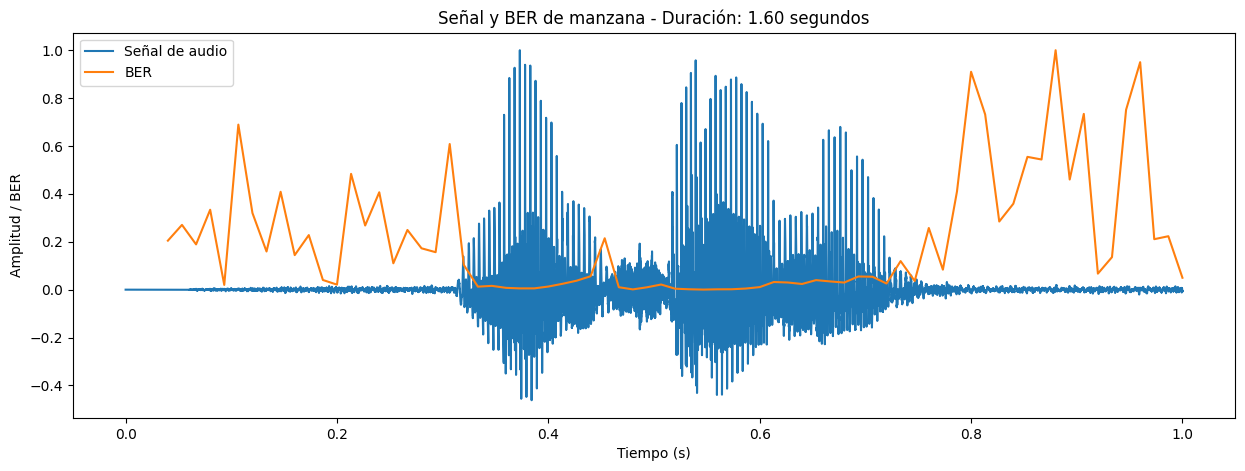

BER: ['nan', 'nan', '0.00', '100.00', '4.37', '2.94', '0.28', '0.58', '0.34', '0.03', '0.03', '0.01', '0.00', '0.01', '0.05', '0.00', '0.03', '0.05', '0.74', '0.06', '0.05', '0.04', '0.04', '0.01', '0.00', '0.02', '0.02', '0.01', '0.02', '0.02', '0.05', '0.01', '0.21', '0.19', '0.15', '1.27', '7.82', '1.15', '2.47', '3.97', '1.12', '2.69', '0.38', '0.28', '1.69', '0.39', '2.42', '4.10', '1.64', '0.45', '2.03', '5.66', '15.42', '20.29', '3.99', '21.06', '28.37', '39.40', '35.51', '22.92']


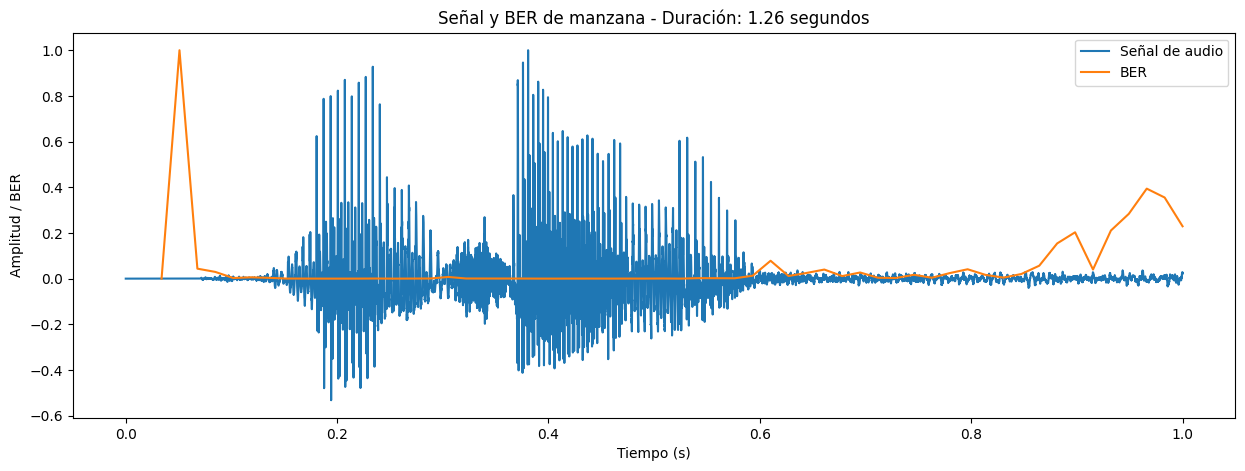

BER: ['nan', 'nan', '0.00', '100.00', '0.42', '1.56', '0.86', '0.13', '0.05', '0.39', '0.29', '3.08', '1.25', '1.99', '1.37', '7.03', '16.83', '2.99', '0.17', '0.01', '0.02', '0.00', '0.06', '0.19', '0.02', '0.21', '1.09', '0.16', '0.05', '0.02', '0.10', '0.01', '0.01', '0.02', '0.05', '0.27', '0.01', '0.03', '0.06', '0.07', '0.02', '0.06', '0.20', '0.52', '3.41', '2.47', '1.58', '2.25', '3.73', '2.73', '9.03', '2.96', '1.41', '3.06', '1.87', '1.54', '2.82', '2.13', '2.33', '4.17', '7.12', '2.71', '3.30']


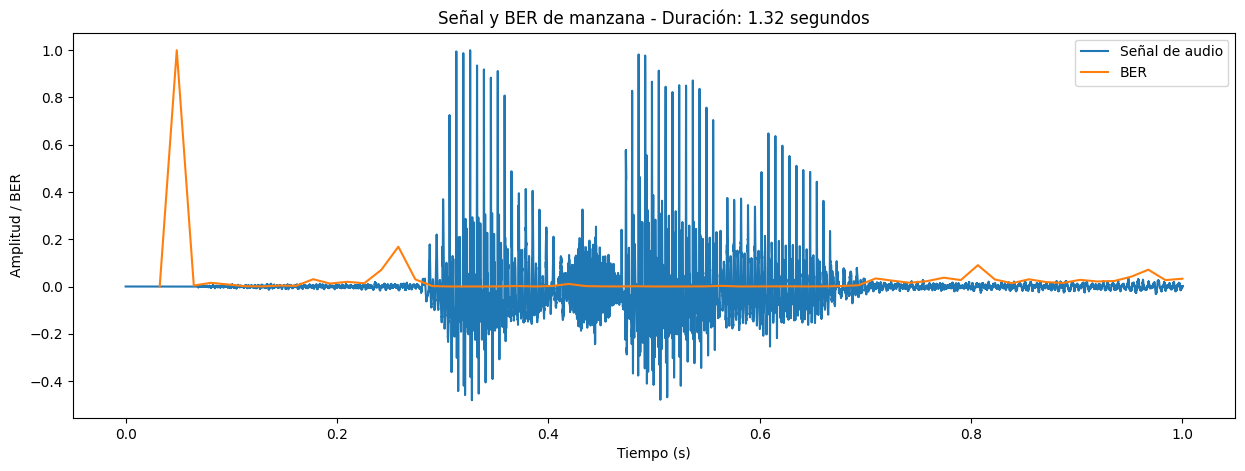

BER: ['6.14', '56.37', '72.88', '79.80', '91.67', '83.03', '86.89', '60.95', '100.00', '80.83', '71.11', '87.35', '98.12', '85.01', '82.67', '66.61', '82.37', '69.37', '51.61', '15.81', '5.43', '0.61', '0.13', '0.17', '1.59', '1.64', '9.55', '2.36', '1.02', '4.42', '9.57', '5.09', '32.16', '66.63', '36.21', '6.35', '1.08', '0.27', '1.70', '0.97', '0.08', '0.15', '1.17', '2.67', '3.97', '6.58', '1.22', '3.20', '7.53', '4.14', '1.22', '13.70', '36.42', '5.89', '17.01']


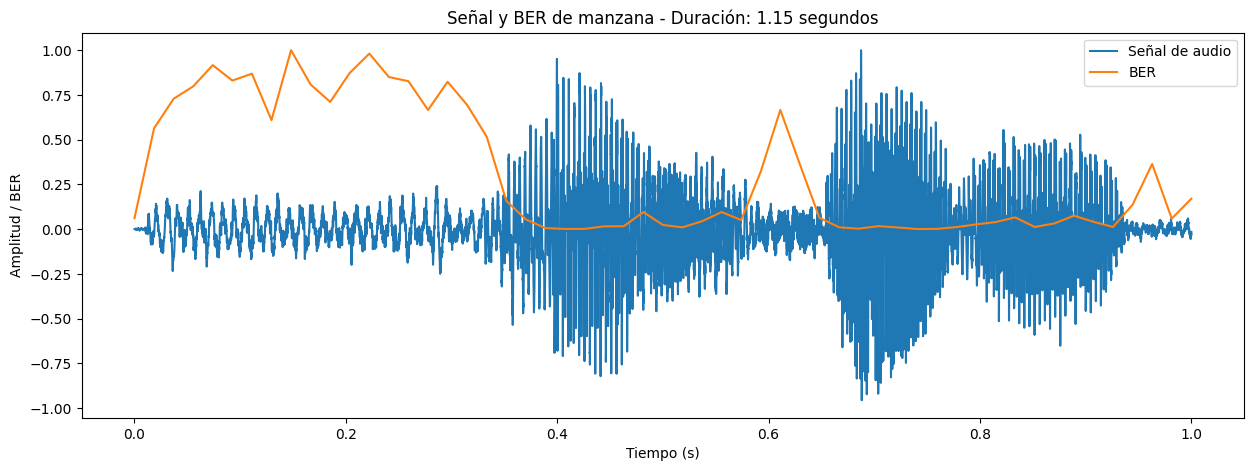

BER: ['2.49', '13.41', '21.28', '9.20', '12.01', '61.99', '43.93', '9.00', '23.49', '11.88', '8.32', '49.80', '24.99', '26.74', '42.25', '49.21', '45.71', '31.21', '43.89', '23.14', '17.11', '34.24', '24.45', '52.53', '65.63', '53.32', '37.02', '19.75', '34.11', '27.32', '14.55', '3.78', '23.81', '14.00', '10.55', '5.36', '3.50', '7.22', '9.18', '9.13', '4.07', '2.99', '6.78', '5.28', '3.30', '5.32', '0.71', '0.86', '1.08', '7.17', '1.98', '6.18', '7.67', '1.37', '8.13', '8.92', '11.94', '3.86', '14.89', '17.10', '18.85', '3.33', '10.00', '16.69', '13.75', '18.82', '17.07', '15.01', '11.66', '17.69', '42.91', '69.02', '57.25', '48.45', '32.26', '35.86', '24.67', '34.51', '80.53', '100.00', '21.71', '9.86', '27.75', '6.85', '9.69', '11.49', '12.81', '15.19', '17.11', '15.05', '16.77', '34.67', '53.83', '75.31', '65.39', '63.81', '39.12', '22.51', '19.15', '42.45', '36.82', '34.44', '31.64', '64.21', '89.66', '60.09', '32.48', '40.91', '73.68', '34.34', '38.29', '30.48', '28.19', '27.26'

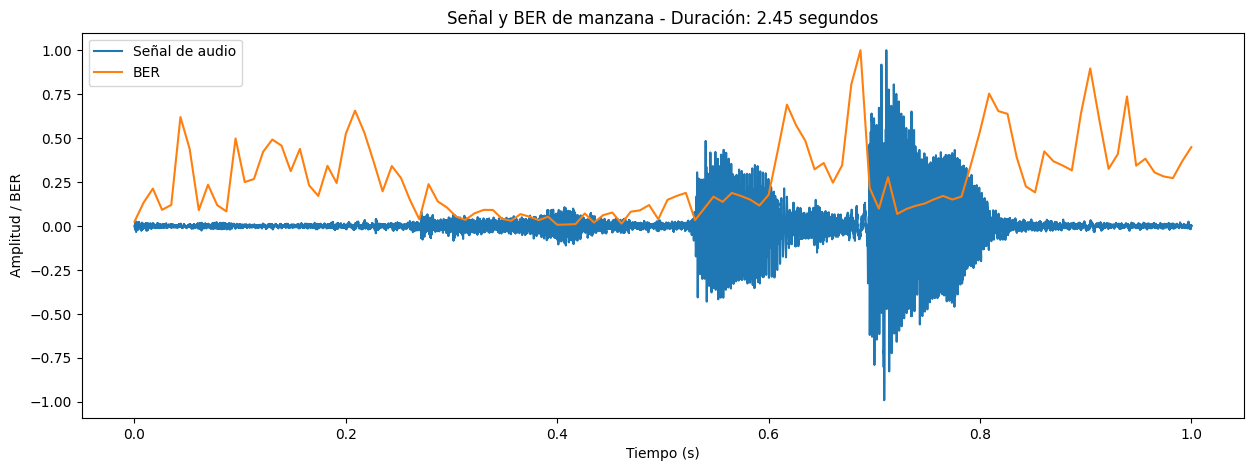

BER: ['1.10', '0.76', '0.64', '6.00', '13.04', '1.08', '6.44', '37.17', '31.02', '73.55', '20.01', '28.09', '19.72', '5.81', '0.30', '0.13', '0.07', '0.07', '0.03', '0.06', '0.22', '0.14', '0.24', '0.14', '2.06', '9.30', '14.56', '5.92', '4.75', '7.28', '0.10', '0.24', '0.14', '0.04', '0.10', '0.17', '0.33', '0.18', '0.02', '0.05', '0.18', '0.48', '0.51', '1.40', '1.20', '1.51', '2.66', '39.56', '32.72', '64.22', '52.64', '28.12', '60.07', '17.14', '51.75', '76.46', '35.75', '21.46', '9.19', '28.53', '16.68', '23.58', '5.86', '27.02', '67.57', '100.00', '34.55', '39.82', '72.40', '66.63']


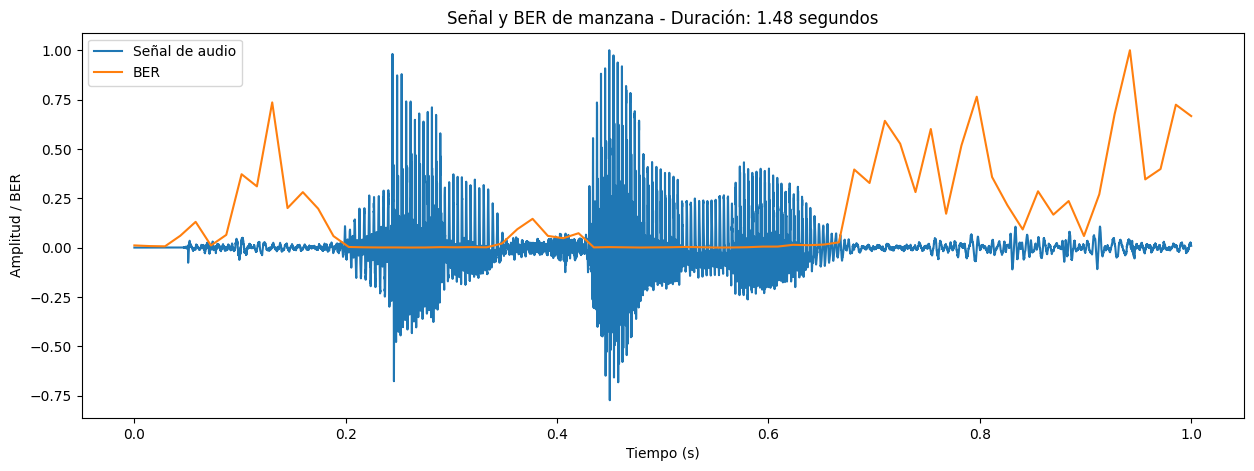

BER: ['100.00', '71.91', '26.32', '25.89', '16.96', '13.04', '25.63', '22.59', '17.53', '44.71', '6.57', '27.40', '52.50', '56.31', '52.13', '49.57', '28.14', '39.46', '43.89', '58.08', '53.83', '66.11', '0.28', '12.28', '30.94', '19.62', '16.01', '19.86', '16.50', '15.71', '35.42', '42.57', '59.52', '83.77', '43.15', '1.39', '0.22', '0.22', '0.03', '3.30', '3.56', '4.10', '3.74', '4.72', '4.94', '7.42', '15.28', '19.51', '12.29', '26.05', '38.13', '54.40', '48.68', '25.69', '25.19', '45.69', '79.05', '43.48', '26.84', '47.54', '64.52', '50.96', '62.20', '68.49', '34.70', '30.38', '15.92', '9.20', '6.44']


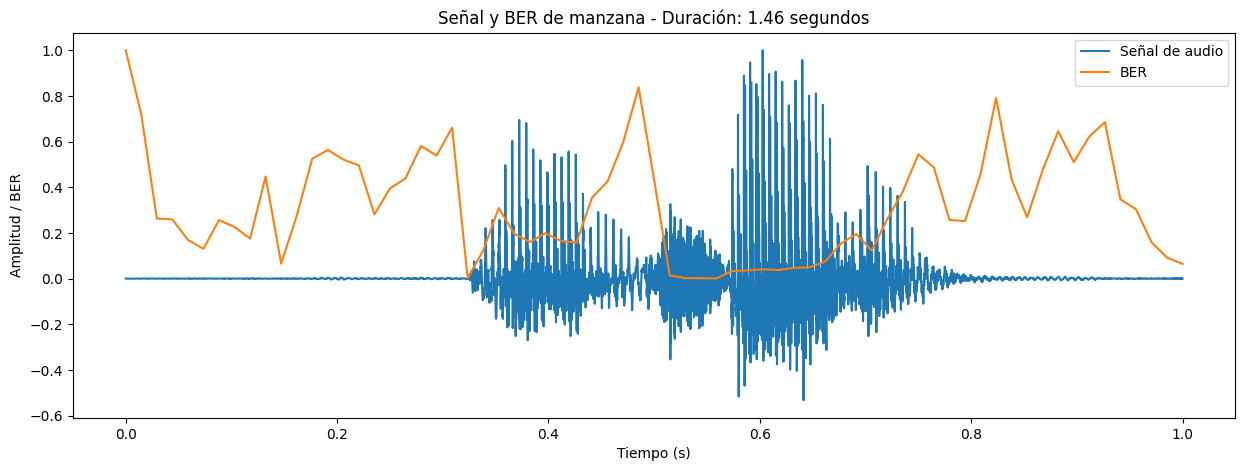

In [257]:
cutoff = 2000
features = dict.fromkeys(fruit_types)
split_frequency = 2100
# Extracción de características
fruit = 'manzana'
for audio in original[fruit]:
        signal, sr, duration = load_audio(audio)
        spec = librosa.stft(signal, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
        BER  = band_energy_ratio(spec, split_frequency, sr)
        BER /= np.nanmax(BER)
        frames = range(len(BER))
        t = librosa.frames_to_time(frames, hop_length=HOP_SIZE)
        t /= t[-1]
        tempo = time_vector(signal, duration)
        print("BER: {}".format(["{:.2f}".format(valor * 100) for valor in BER]))
        plt.figure(figsize=(15, 5))

        plt.plot(tempo/tempo[-1], signal/np.max(np.abs(signal)), label='Señal de audio')
        plt.plot(t, BER, label='BER')
        plt.title(f'Señal y BER de {fruit} - Duración: {duration:.2f} segundos')
        plt.xlabel('Tiempo (s)')
        plt.ylabel('Amplitud / BER')
        plt.legend()  # Mostrar leyenda con etiquetas

        plt.show()